The function ***process_angle_string***  takes an input string describing an angle $d^circ m'$ as *d_m* and converts it to a float value corresponding to that angle in degrees

The function ***VGP*** takes coordinates $\lambda_{s},\varphi_{s}$ of the site and the angles $I$ and $D$ describing the orientation of a magnetic field measured at some moment in that site (all in radians). It returns the coordinates of the corresponding **Virtual Geomagnetic Pole (VGP)**, also in radians. As shown in the report, the equations for the VGP are:

$$\lambda_{VGP}=\arcsin\left(\sin\lambda_{s}\cos p+\cos\lambda_{s}\sin p\cos D\right)$$

$$\varphi_{VGP}=\begin{cases}\varphi_s+\arcsin\left(\frac{\sin p\sin D}{\cos\lambda_{VGP}}\right)   \Longleftarrow   \cos p \geqslant \sin\lambda_s\sin\lambda_{VGP}\\ \varphi_s+\pi-\arcsin\left(\frac{\sin p\sin D}{\cos\lambda_{VGP}}\right) \Longleftarrow \cos p < \sin\lambda_s\sin\lambda_{VGP}\end{cases}$$

where $p=\arctan\left(\frac{2}{\tan I}\right)$.

The class **site_data** is designed to handle data describing the magnetic field at a given location at different times, calculate the VGP timeseries and visualize it with static plots:

A **site_data** object is initiated by providing strings desribing the coordinates of the site (in the $d^\circ m'$ as *d_m* format to be processed with ***process_angle_string***) and a data filename. An optional parameter *file_header* informs how many lines of the file should be skipped as a header (in the case of **Eric_data** it is equal to $1$ - the first line contains the labels for each column and only from the second line onwards can we find actual data). Upon initialization, the following attributes are immediately generated:
* *latitude* - the site's latitude in degrees
* *longitude* - the site's longitude in degrees
* *location* - a string describing the site's location, useful for printing and plots
* *T* - an array of moments in time to which each datapoint corresponds, in units of years elepsed since then until contemporary days
* *D* - an array of $D$ -  declinations of the magnetic field at each moment, in degrees, as read from the input file
* *I* - an array of $I$ - inclinations of the magnetic field at each moment, in degrees, as read from the input file
* *F* - an array of $F$ - magnetic field intensities at the site in each moment, in units of $\mu T$
* *n* - the length of the timeseries (number of datapoints)
* *VGPs* - an array of pairs of $\lambda_{VGP},\varphi_{VGP}$ coordinates of the VGP at each moment, in radians, calculated using the ***VGP*** function
* *B_spline_tck* - parameters of a B-spline interpolation of the VGP time evolution curve in polar coordinates centered around the Earth's North Pole (see report for details)
* *B_spline_u* - knots of that B-spline corresponding to each data point

The function ***time_range_to_jk*** of the **site_data** class takes *time_range* - a pair of time coordinates expressed in units of years elapsed since each moment and returns *j* and *k* - corresponding indices of that time range covered in the *T* array (so that they can be passed to other functions or used to access relevant data points).

The function ***B_spline_curve*** of the **site_data** class takes start and end points *j* and *k* (indices of the *T* array) and a *resolution* It then calculates polar coordinates of points on a B-spline interpolated curve of VGP locations over a corresponding time interval, with each interval between data points subdivided into a *resolution* number of subintervals. Corresponding *u_new* - array of coordinates along the curve for each point - is also returned. 

The function ***longitude_continuity_correction*** of the **site_data** class takes *j* and *k* (indices of the *T* array) and a *treshold* and shifts values of $\varphi_{VGP}$ in that time range so as to avoid discontinuities where neighbouring values were calculated $360^\circ$ apart. *treshold* is the required proximity of the difference between neighbouring longitudes to $360^\circ$ in order to apply a correction at any given moment. The function returns an array of longitudes in degrees. Useful for generating a simple plot without discontinuities.

The function ***plot_evolution*** of the **site_data** class can create a simple or polar plot of the VGP location evolution in time, modifiable with following keywords:
* *figsize* is the size of the figure, default (10,7)
* *plot_type* can be either "simple" or "polar" - a string defining a desired plot type. By default "simple"
* *with_dots* is a flag determining whether points should be drawn on top of the curves. By default **False**
* *time_range* is a pair of time coordinates expressed in units of years elapsed since each moment, to be processed by the function ***time_range_to_jk***. Default value of **None** is interpreted in such a way, that the entire time interval covered by the data will be plotted
* *B_spline* is a flag relevant only in the case of a polar plot. If set to the default value of **False**, consecutive VGPs computed from the data will be connected by straight lines. If **True** a B-spline interpolation will be used instead. The advantage is a more elegant plot, a disadvantage is the fact that intermediate values may not be physical.
* *B_spline_resolution* defines the number of subintervals each time interval between consecutive data points should be divided into. Default value of $10$ is usually sufficient to obtain smooth B-spline plots without unnecessarily high computational load
* *B_spline_from_cmap* is a flag deciding whether the B-spline curve should be drawn using *cmap* values, with color indicating the time coordinate (default value **True**) or as a monochrome gray curve (**False**, useful for the animation
* *cmap* is the color map to be used, only relevant for the polar plot Default *cm.plasma*
* *receive_ax* is a flag informing whether the plot should be drawn on an existent figure. By default **False**, if **True**, *fig* and *ax* must be provided
* If *suppress_title* (**False** by default) is set to **True**, the generated plot will not be given a title, otherwise a descriptive title is generated
* *longitude_correction_treshold* is a treshold for ***longitude_continuity_correction***, only applicable for a simple plot. A default value of $5^\circ$ lead to the desired results in the first tests, but for the site data and periods of eventual interest, it had to be boosted up to $100^\circ$, except for the plot of the entire period, see Figure 10 and discussion in section 3.2.1 in the report.

The function ***plot_evolution_by_subperiods*** of the class **site_data** generates figures with a polar and simple plot side by side for subperiods of the time range spanned by the data as defined by the user:
* *timestamps* is a list of moments in time that would be used to slice the data into subintervals. Useful if some shorter periods have a higher variety than other longer periods, as is the case for **Eric_data**. Default to **None**, in which case *subdivide* will be used to generate even subperiods
* *subdivide* the number of equaly long subperiods to divide the time interval into. Default to $5$. Disregarded if *timestamps* are provided
* *figsize* is a size of each plot. Default to (7,7)
* *B_spline_resolution* - same as for ***plot_evolution***, default to $10$
* *save_to* is a basename for files to save the figure at. If left at default (empty string) the figures won't be saved
* *save_format* is an extension for the figures to be saved at. Default to ".png". Disregarded if *save_to* was not provided
* *longitude_correction_tresholds* is a list of tresholds for each interval to be used with ***longitude_continuity_correction*** to avoid discontinuities on the simple plots. Default to **None**, in which case a default value of $5^\circ$ will be passed for each interval. The ability to manually adjust the treshold for each interval was created due to an initial struggle to manually find right treshold value(s) so as to remove any unwanted discontinuities. Ultimately it is probably unnecassary 

The function **init** updates a line of a dynamic plot and is used for animations

<IPython.core.display.Javascript object>


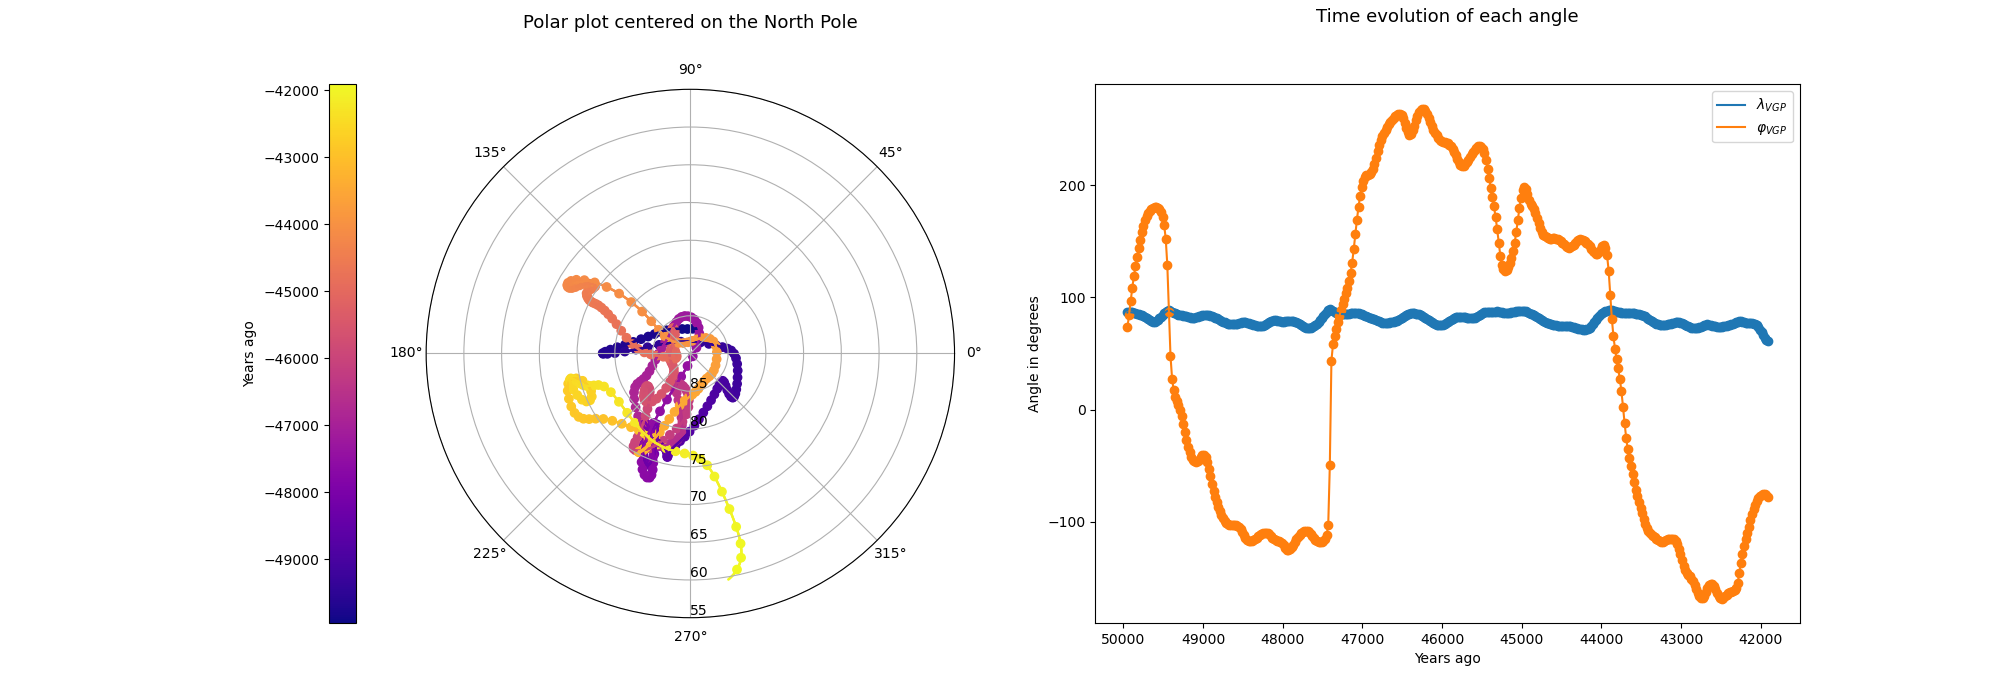

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import splprep, splev
from matplotlib import animation



def process_angle_string (s):
    i=0
    while not s[i]=="_":
        i+=1
    angle=float(s[:i])
    if (angle>=0):
        angle+=float(s[i+1:])/60.0
    else:
        angle-=float(s[i+1:])/60.0
    return angle

def VGP(lat,lon,I,D):
    p = np.arctan(2/(np.tan(I)))
    cp = np.cos(p)
    sp = np.sin(p)
    slp = np.sin(lat)*cp+np.cos(lat)*sp*np.cos(D)
    lat_pole = np.arcsin(slp)
    beta = np.arcsin(sp*np.sin(D)/np.cos(lat_pole))
    crit = np.sin(lat)*slp
    if cp >= crit:
        lon_pole = lon + beta
    else:
        lon_pole = lon+np.pi-beta
    if lon_pole<0:
        lon_pole+=2*np.pi
    return [lat_pole, lon_pole]

class site_data:

    def __init__(self,lat,lon,file,file_header=0):
        i=0
        self.latitude = process_angle_string(lat)
        self.longitude = process_angle_string(lon)
        if self.latitude>=0:
            NS = "N"
        else:
            NS = "S"
        if self.longitude>=0:
            EW = "E"
        else:
            EW = "W"
        self.location = "location {:0.3f} {} {:0.3f} {}.".format(abs(self.latitude),NS,abs(self.longitude),EW)
        data=np.genfromtxt(file,skip_header=file_header)
        self.T = data[:,0]*1000
        self.D = data[:,1]
        self.I = data[:,2]
        self.F = data[:,3]
        self.n = len(self.T)
        self.VGPs = np.array(list(map(lambda i: VGP(np.radians(self.latitude),np.radians(self.longitude),np.radians(self.I[i]),np.radians(self.D[i])),range(len(self.I))))).T
        X = np.cos(self.VGPs[1])*(90-np.degrees(self.VGPs[0]))
        Y = np.sin(self.VGPs[1])*(90-np.degrees(self.VGPs[0]))
        tck, u = splprep([X, Y],s=0)    
        self.B_spline_tck=tck
        self.B_spline_u=u
    
    def __str__(self):
        return "Object containing paleomagnetic data for {}".format(self.location)

    def time_range_to_jk(self,time_range):
        j=0
        jk_max=self.n-1
        if time_range is None:
            k=self.n-1
        else:
            while self.T[j]>time_range[0] and j<jk_max:
                j+=1
            k=j
            while self.T[k]>time_range[1] and k<jk_max:
                k+=1
        return j,k
    
    def B_spline_curve(self,j,k,resolution):
        u_new = np.linspace(self.B_spline_u[j], self.B_spline_u[k], len(self.T[j:k])*resolution)
        curve = splev(u_new, self.B_spline_tck)      
        curve_r=(curve[0]**2+curve[1]**2)**0.5
        curve_th=np.arctan2(curve[1], curve[0])  
        ind=j
        for i in range(len(u_new)):
            if u_new[i]>self.B_spline_u[ind+1]:
                ind+=1
            u_new[i]=-self.T[ind]+(self.T[ind]-self.T[ind+1])*(u_new[i]-self.B_spline_u[ind])/(self.B_spline_u[ind+1]-self.B_spline_u[ind])
        return curve_r,curve_th,u_new
   
    def longitude_continuity_correction(self,j,k,treshold):
        longitudes=np.degrees(self.VGPs[1][j:k])
        for i in range(1,k-j):
            if(abs(abs(longitudes[i]-longitudes[i-1])-360)<treshold):
                if(longitudes[i]>longitudes[i-1]):
                    longitudes[i]-=360
                else:
                    longitudes[i]+=360
        return longitudes
    
    def plot_evolution(self,figsize=(10,7),plot_type="simple",with_dots=False,time_range=None,B_spline=False,B_spline_resolution=10,B_spline_from_cmap=True,cmap=cm.plasma, receive_ax=False, fig=None,ax=None,suppress_title=False,longitude_correction_treshold=5.0):
        j,k = self.time_range_to_jk(time_range)
        if plot_type=="simple":
            if not receive_ax:
                fig, ax = plt.subplots(figsize=figsize)
            longitudes=self.longitude_continuity_correction(j,k,longitude_correction_treshold)
            ax.plot(self.T[j:k],np.degrees(self.VGPs[0][j:k]),label=r'$\lambda_{VGP}$')
            ax.plot(self.T[j:k],longitudes,label=r'$\varphi_{VGP}$')
            ax.set_xlabel("Years ago")
            ax.set_ylabel("Angle in degrees")
            ax.invert_xaxis()
            if with_dots:
                ax.scatter(self.T[j:k],np.degrees(self.VGPs[0][j:k]))
                ax.scatter(self.T[j:k],longitudes)
            ax.legend()
        if plot_type=="polar":
            ylim=max(90-np.degrees(Eric_data.VGPs[0][j:k]))
            if ylim>90:
                ax.plot(np.linspace(0,2*np.pi,1000),[90]*1000,linewidth=3,color="black")
                ax.fill_between(np.linspace(0,2*np.pi,1000),90,ylim+10,color="black",alpha=0.2)
                ax.set_ylim(ylim+10)
                bbox = dict(boxstyle='round', fc='white', ec='white',alpha=0)
                ax.text(3,90+(ylim-90)/2, "S", fontsize=25, bbox=bbox, horizontalalignment='left')
                ax.text(3,70, "N", fontsize=25, bbox=bbox, horizontalalignment='left')
            if not receive_ax:
                fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=figsize)
            if with_dots:
                im=ax.scatter(self.VGPs[1][j:k],90-np.degrees(self.VGPs[0][j:k]),c=-self.T[j:k],cmap=cmap)
            ax.set_ylim(bottom=0)
            ax.set_yticks(np.array(ax.get_yticks()),labels=map(int,90-np.array(ax.get_yticks())))
            ax.set_rlabel_position(-90) 
            if B_spline:
                curve_r,curve_th,u_new = self.B_spline_curve(j,k,B_spline_resolution)
                if B_spline_from_cmap:
                    ax.scatter(curve_th,curve_r,marker=".",s=2,c=u_new,cmap=cmap)
                else:
                    ax.scatter(curve_th,curve_r,marker=".",s=0.2,color="#384e2c")
            else: 
                T_0=-self.T[j]
                T_1=-self.T[k]
                dT=T_0-T_1
                for i in range(j,k):
                    ax.plot(self.VGPs[1][i:i+2],90-np.degrees(self.VGPs[0][i:i+2]),color=cmap((T_0+0.5*(self.T[i]+self.T[i+1]))/dT))
            if not fig is None:
                fig.colorbar(im,label="Years ago",location="left")
        if not suppress_title:
            if time_range is None:
                ax.set_title("Evolution of VGP for {}".format(self.location))
            else:
                ax.set_title("Evolution of VGP for {}\nbetween {} and {} years ago".format(self.location,min(time_range[0],int(self.T[0])),max(time_range[1],int(self.T[-1]))))
    
    def plot_evolution_by_subperiods(self,timestamps=None,subdivide=5,figsize=(10,7),B_spline_resolution=10,save_to="",save_format=".png",longitude_correction_tresholds=None):
        if timestamps is None:
            timestamps = self.T[np.array([int(i*(self.n-1)/subdivide) for i in range(subdivide+1)])]
        else:
            subdivide = len(timestamps)-1
        if longitude_correction_tresholds is None:
            longitude_correction_tresholds=[5]*subdivide
        for i in range(subdivide):
            fig = plt.figure(figsize=(figsize[0]*2,figsize[1]))
            ax = fig.add_subplot(121, polar=True)
            self.plot_evolution(plot_type="polar",with_dots=True,time_range=[timestamps[i],timestamps[i+1]],B_spline=True,B_spline_resolution=B_spline_resolution,receive_ax=True,fig=fig,ax=ax,suppress_title=True)                    
            ax.set_title("Polar plot centered on the North Pole",y=1.1,fontsize=13)
            ax = fig.add_subplot(122)
            self.plot_evolution(plot_type="simple",with_dots=True,time_range=[timestamps[i],timestamps[i+1]],receive_ax=True,fig=fig,ax=ax,suppress_title=True,longitude_correction_treshold=longitude_correction_tresholds[i])  
            ax.set_title("Time evolution of each angle",y=1.1,fontsize=13)
            fig.suptitle("Evolution of VGP for {} between {} and {} years ago".format(self.location,timestamps[i],timestamps[i+1]),y=1.04,fontsize=14)
            if not save_to == "":
                fig.savefig(save_to+"_"+str(i+1)+"_of_"+str(subdivide)+save_format,bbox_inches='tight')
                                
def init():
    line.set_data([], [])
    return line,

Eric_data = site_data("39_32.891","-8_46.266","./LSMOD2_predictions.dat",file_header=1)
Eric_data.plot_evolution_by_subperiods(timestamps=[499550,41900,40100,36000,32000,29950],B_spline_resolution=10,save_to="Eric_VGP_evolution",save_format=".jpg",longitude_correction_tresholds=[100,100,100,100,100])
Eric_data.plot_evolution_by_subperiods(timestamps=[49950,29950],B_spline_resolution=10,save_to="Eric_VGP_evolution",save_format=".jpg",longitude_correction_tresholds=[50])

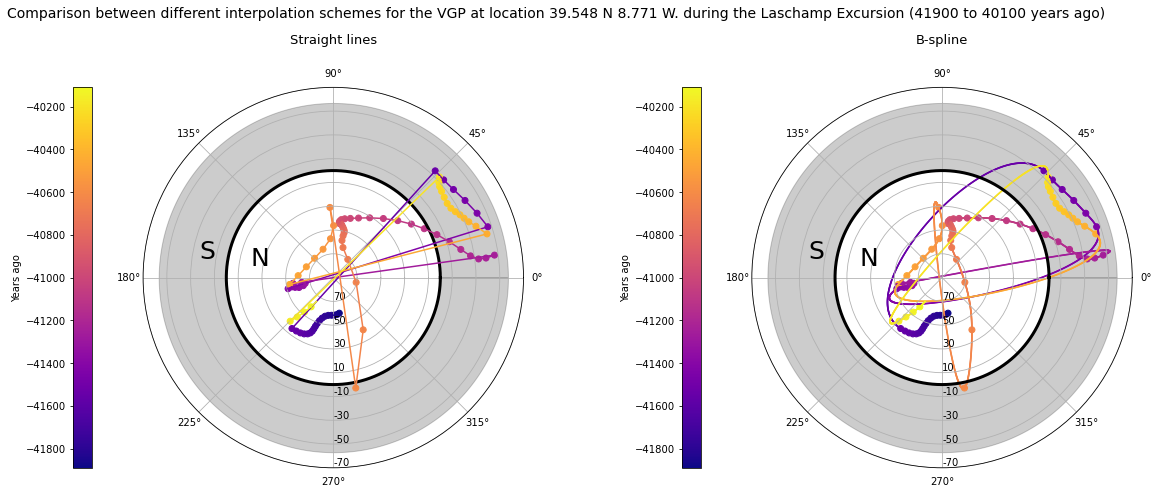

In [15]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(121, polar=True)
Eric_data.plot_evolution(plot_type="polar",figsize=(10,10),with_dots=True,time_range=[41900,40100],receive_ax=True,fig=fig,ax=ax,suppress_title=True)
ax.set_title("Straight lines",y=1.1,fontsize=13)
ax = fig.add_subplot(122, polar=True)
Eric_data.plot_evolution(plot_type="polar",figsize=(10,10),with_dots=True,time_range=[41900,40100],B_spline=True,B_spline_resolution=50,receive_ax=True,fig=fig,ax=ax,suppress_title=True)
ax.set_title("B-spline",y=1.1,fontsize=13)
fig.suptitle("Comparison between different interpolation schemes for the VGP at {} during the Laschamp Excursion (41900 to 40100 years ago)".format(Eric_data.location),y=1.04,fontsize=14)
fig.savefig("Straight_vs_Bspline.png",bbox_inches='tight')

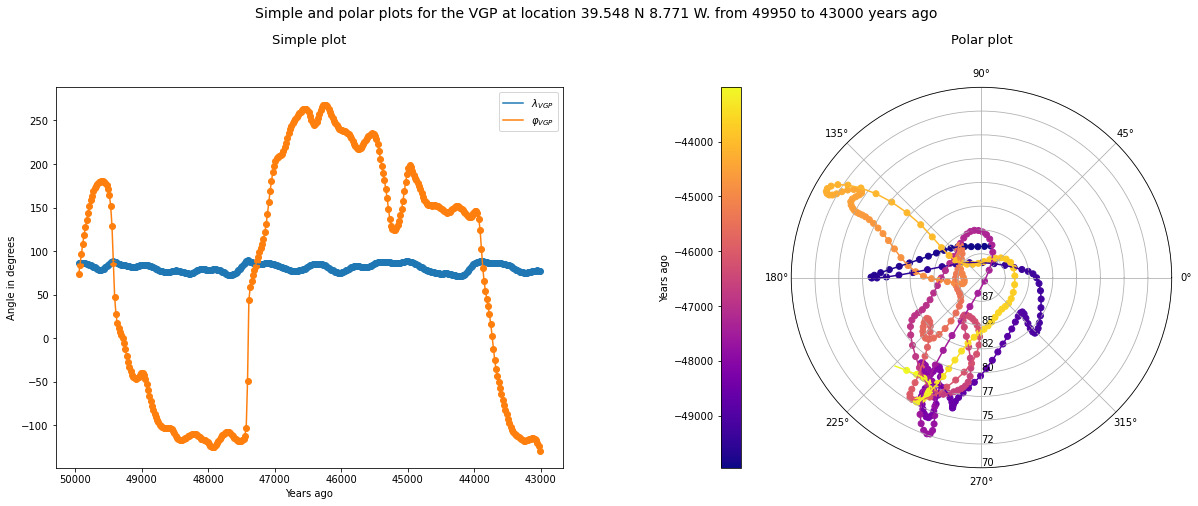

In [19]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(121)
Eric_data.plot_evolution(plot_type="simple",figsize=(10,10),with_dots=True,time_range=[49950,43000],receive_ax=True,fig=fig,ax=ax,suppress_title=True,longitude_correction_treshold=100)
ax.set_title("Simple plot",y=1.1,fontsize=13)
ax = fig.add_subplot(122, polar=True)
Eric_data.plot_evolution(plot_type="polar",figsize=(10,10),with_dots=True,time_range=[49950,43000],receive_ax=True,fig=fig,ax=ax,suppress_title=True)
ax.set_title("Polar plot",y=1.1,fontsize=13)
fig.suptitle("Simple and polar plots for the VGP at {} from 49950 to 43000 years ago".format(Eric_data.location),y=1.04,fontsize=14)
fig.savefig("simple_vs_polar.png",bbox_inches='tight')

The cells below create animations of VGP evolution with time, for the entire period and for each subperiod. They are generated in polar coordinates $(r=90^\circ-\lambda_{VGP},\theta=\varphi_{VGP})$, with a gray curve showing the path over the entire period and a colored path showing the position at a given moment and $\frac{l}{r}$ moments before. $r=10$ is the B-spline resolution, $m$ the frequency of sampling the data in the animation and $l$ the number of points from the B-spline to be shown as a colorful curve

<IPython.core.display.Javascript object>


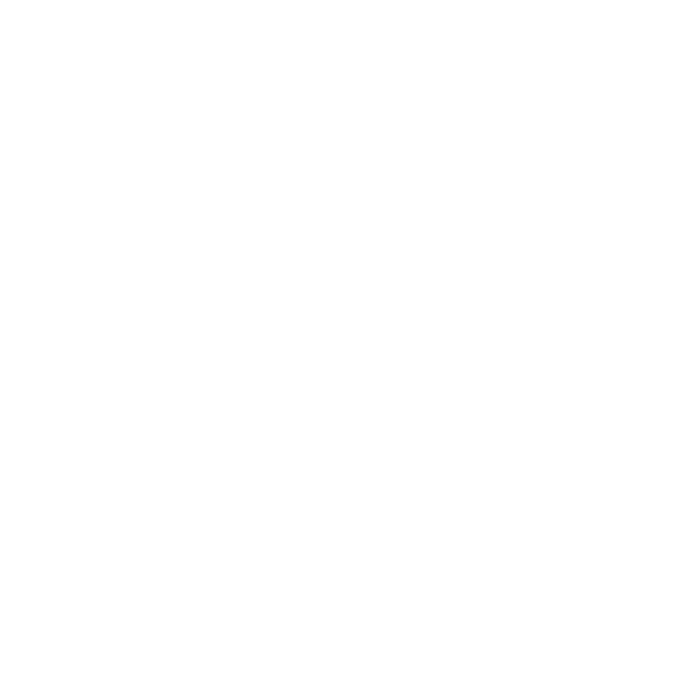

In [20]:
from IPython.display import HTML
%matplotlib notebook

l=200
m=50
r=10

def line_from_data(i):
    sc.set_offsets(np.column_stack((curve_th[i*m:i*m+l], curve_r[i*m:i*m+l])))
    text.set_text('{:.0f} years ago'.format(Eric_data.T[int((i+1+(l/m))*(m/r))]))

time_range=[Eric_data.T[0],Eric_data.T[-1]]
j,k=Eric_data.time_range_to_jk(time_range)
curve_r,curve_th,u_new = Eric_data.B_spline_curve(j,k,r)
figsize=(7,7)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=figsize)
ylim=max(90-np.degrees(Eric_data.VGPs[0][j:k]))
if ylim>90:
    ax.plot(np.linspace(0,2*np.pi,1000),[90]*1000,linewidth=3,color="black")
    ax.fill_between(np.linspace(0,2*np.pi,1000),90,ylim+10,color="black",alpha=0.2)
    ax.set_ylim(ylim+10)
    bbox = dict(boxstyle='round', fc='white', ec='white',alpha=0)
    ax.text(3,90+(ylim-90)/2, "S", fontsize=25, bbox=bbox, horizontalalignment='left')
    ax.text(3,70, "N", fontsize=25, bbox=bbox, horizontalalignment='left')
text = ax.text(0, 0.95, '', transform=ax.transAxes, ha='center')
Eric_data.plot_evolution(time_range=time_range,figsize=figsize,plot_type="polar",with_dots=False,B_spline=True,B_spline_from_cmap=False,receive_ax=True,suppress_title=True,ax=ax)
sc = ax.scatter(np.zeros(l), np.zeros(l), c=np.linspace(0,1,l), marker=".", s=20, cmap='plasma')
ax.set_title("Evolution of VGP for {}\nbetween {} and {} years ago".format(Eric_data.location,time_range[0],time_range[1]))
anim = animation.FuncAnimation(fig, line_from_data, frames=int((len(curve_r)-l)/m),interval=100)
plt.close()
anim.save('VGP_{}_to_{}.gif'.format(time_range[0],time_range[1]), writer='imagemagick')
HTML(anim.to_html5_video(embed_limit=1000))


<IPython.core.display.Javascript object>


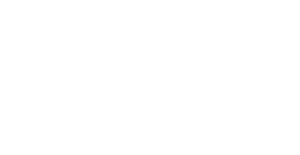

In [22]:
time_range=[49950,41900]
j,k=Eric_data.time_range_to_jk(time_range)
curve_r,curve_th,u_new = Eric_data.B_spline_curve(j,k,r)
figsize=(7,7)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=figsize)
ax.set_ylim(0,max(90-np.degrees(Eric_data.VGPs[0][j:k])))
text = ax.text(0, 0.95, '', transform=ax.transAxes, ha='center')
Eric_data.plot_evolution(time_range=time_range,figsize=figsize,plot_type="polar",with_dots=False,B_spline=True,B_spline_from_cmap=False,receive_ax=True,suppress_title=True,ax=ax)
sc = ax.scatter(np.zeros(l), np.zeros(l), c=np.linspace(0,1,l), marker=".", s=20, cmap='plasma')
ax.set_title("Evolution of VGP for {}\nbetween {} and {} years ago".format(Eric_data.location,time_range[0],time_range[1]))
anim = animation.FuncAnimation(fig, line_from_data, frames=int((len(curve_r)-l)/m),interval=100)
plt.close()
anim.save('VGP_{}_to_{}.gif'.format(time_range[0],time_range[1]), writer='imagemagick')
HTML(anim.to_html5_video(embed_limit=1000))

In [26]:
time_range=[41900,40100]
j,k=Eric_data.time_range_to_jk(time_range)
curve_r,curve_th,u_new = Eric_data.B_spline_curve(j,k,r)
figsize=(7,7)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=figsize)
ax.set_ylim(0,max(90-np.degrees(Eric_data.VGPs[0][j:k])))
text = ax.text(0, 0.95, '', transform=ax.transAxes, ha='center')
Eric_data.plot_evolution(time_range=time_range,figsize=figsize,plot_type="polar",with_dots=False,B_spline=True,B_spline_from_cmap=False,receive_ax=True,suppress_title=True,ax=ax)
sc = ax.scatter(np.zeros(l), np.zeros(l), c=np.linspace(0,1,l), marker=".", s=20, cmap='plasma')
ax.set_title("Evolution of VGP for {}\nbetween {} and {} years ago".format(Eric_data.location,time_range[0],time_range[1]))
anim = animation.FuncAnimation(fig, line_from_data, frames=int((len(curve_r)-l)/m),interval=100)
plt.close()
anim.save('VGP_{}_to_{}.gif'.format(time_range[0],time_range[1]), writer='imagemagick')
HTML(anim.to_html5_video(embed_limit=1000))

<IPython.core.display.Javascript object>


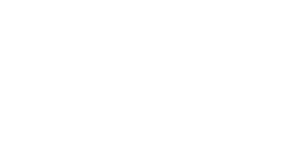

In [24]:
time_range=[40100,29950]
j,k=Eric_data.time_range_to_jk(time_range)
curve_r,curve_th,u_new = Eric_data.B_spline_curve(j,k,r)
figsize=(7,7)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=figsize)
ax.set_ylim(0,max(90-np.degrees(Eric_data.VGPs[0][j:k])))
text = ax.text(0, 0.95, '', transform=ax.transAxes, ha='center')
Eric_data.plot_evolution(time_range=time_range,figsize=figsize,plot_type="polar",with_dots=False,B_spline=True,B_spline_from_cmap=False,receive_ax=True,suppress_title=True,ax=ax)
sc = ax.scatter(np.zeros(l), np.zeros(l), c=np.linspace(0,1,l), marker=".", s=20, cmap='plasma')
ax.set_title("Evolution of VGP for {}\nbetween {} and {} years ago".format(Eric_data.location,time_range[0],time_range[1]))
anim = animation.FuncAnimation(fig, line_from_data, frames=int((len(curve_r)-l)/m),interval=100)
plt.close()
anim.save('VGP_{}_to_{}.gif'.format(time_range[0],time_range[1]), writer='imagemagick')
HTML(anim.to_html5_video(embed_limit=1000))